# Peter và Sói: Môi Trường Thực Tế

Trong tình huống của chúng ta, Peter có thể di chuyển gần như không cảm thấy mệt mỏi hay đói. Trong một thế giới thực tế hơn, cậu ấy cần phải ngồi xuống nghỉ ngơi và ăn uống để duy trì sức khỏe. Hãy làm cho thế giới của chúng ta trở nên thực tế hơn bằng cách áp dụng các quy tắc sau:

1. Khi di chuyển từ nơi này sang nơi khác, Peter sẽ mất **năng lượng** và tăng thêm **mệt mỏi**.
2. Peter có thể tăng năng lượng bằng cách ăn táo.
3. Peter có thể giảm mệt mỏi bằng cách nghỉ ngơi dưới gốc cây hoặc trên cỏ (tức là đi vào vị trí trên bảng có cây hoặc cỏ - ô màu xanh lá).
4. Peter cần tìm và tiêu diệt con sói.
5. Để tiêu diệt con sói, Peter cần đạt mức năng lượng và mệt mỏi nhất định, nếu không cậu ấy sẽ thua trong trận chiến.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

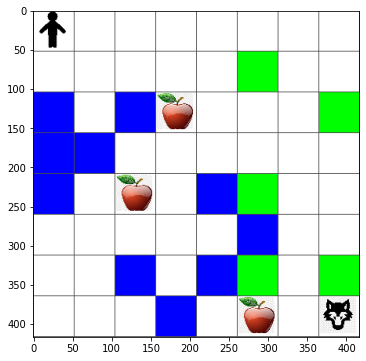

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Định nghĩa trạng thái

Trong các quy tắc trò chơi mới, chúng ta cần theo dõi năng lượng và sự mệt mỏi ở mỗi trạng thái bàn cờ. Vì vậy, chúng ta sẽ tạo một đối tượng `state` để chứa tất cả thông tin cần thiết về trạng thái hiện tại của vấn đề, bao gồm trạng thái của bàn cờ, mức năng lượng và sự mệt mỏi hiện tại, và liệu chúng ta có thể đánh bại con sói khi ở trạng thái cuối hay không:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Hàm Thưởng

### Tổng quan
Hàm thưởng là một phần quan trọng trong việc thiết kế hệ thống học tăng cường. Nó định nghĩa cách mà một tác nhân nhận được phản hồi từ môi trường để hướng dẫn hành vi của mình.

### Cách hoạt động
Hàm thưởng thường được thiết kế để khuyến khích tác nhân đạt được mục tiêu cụ thể. Mỗi hành động mà tác nhân thực hiện sẽ dẫn đến một giá trị thưởng, giá trị này có thể là dương, âm hoặc bằng không.

### Ví dụ
Dưới đây là một ví dụ đơn giản về cách định nghĩa hàm thưởng:

```python
def reward_function(state, action):
    if state == "goal_state":
        return 10  # Thưởng cao khi đạt được mục tiêu
    elif action == "invalid_action":
        return -5  # Phạt khi thực hiện hành động không hợp lệ
    else:
        return 0  # Không thưởng hoặc phạt cho các hành động khác
```

### Lưu ý
[!NOTE] Hàm thưởng cần được thiết kế cẩn thận để tránh việc khuyến khích hành vi không mong muốn. Ví dụ, nếu tác nhân nhận được thưởng cao khi thực hiện một hành động cụ thể, nó có thể lặp lại hành động đó mà không quan tâm đến mục tiêu dài hạn.

### Các phương pháp phổ biến
- **Thưởng theo mục tiêu:** Tác nhân nhận được thưởng khi đạt được trạng thái mục tiêu.
- **Thưởng theo tiến trình:** Tác nhân nhận được thưởng dựa trên mức độ tiến bộ hướng tới mục tiêu.
- **Thưởng theo hành vi:** Tác nhân nhận được thưởng khi thực hiện hành vi mong muốn.

### Cảnh báo
[!WARNING] Tránh thiết kế hàm thưởng quá phức tạp, vì điều này có thể làm cho việc học của tác nhân trở nên khó khăn và không hiệu quả.

### Mẹo
[!TIP] Hãy thử nghiệm nhiều hàm thưởng khác nhau để tìm ra thiết kế phù hợp nhất với môi trường và mục tiêu của bạn.

### Kết luận
Hàm thưởng đóng vai trò quan trọng trong việc định hình hành vi của tác nhân. Một hàm thưởng được thiết kế tốt sẽ giúp tác nhân học nhanh hơn và đạt được kết quả tốt hơn.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Thuật toán Q-Learning

Thuật toán học thực tế hầu như không thay đổi, chúng ta chỉ sử dụng `state` thay vì chỉ vị trí trên bảng.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

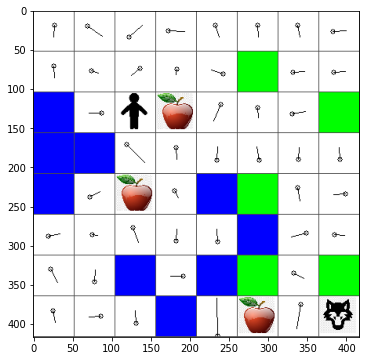

In [11]:
m.plot(Q)

## Kết quả

Hãy xem liệu chúng ta đã thành công trong việc huấn luyện Peter để chiến đấu với con sói chưa!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Chúng ta hiện thấy ít trường hợp chết đuối hơn nhiều, nhưng Peter vẫn không phải lúc nào cũng có thể giết được con sói. Hãy thử nghiệm và xem liệu bạn có thể cải thiện kết quả này bằng cách điều chỉnh các siêu tham số.


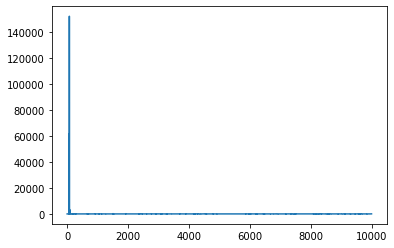

In [13]:
plt.plot(lpath)


---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn thông tin chính thức. Đối với các thông tin quan trọng, nên sử dụng dịch vụ dịch thuật chuyên nghiệp từ con người. Chúng tôi không chịu trách nhiệm cho bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
